# Data Visualization Notebook

## Objectives

*   Answer business requirement 1: 
    * The client is interested to have a study to visually differentiate a parasitized and uninfected cell.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between parasite-contained and uninfected cell images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.


## Additional Comments | Insights | Conclusions




---

# Set Data Directory

---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/PP5-Plant-Disease-Classification/jupyter_notebooks')
print("You set a new current directory")

You set a new current directory


In [4]:

work_dir = os.getcwd()
work_dir

'/workspace/PP5-Plant-Disease-Classification/jupyter_notebooks'

## Set input directories

Set train, validation and test paths.

In [9]:
my_data_dir = '../inputs/plants_dataset'
train_path = my_data_dir + '/Train'
val_path = my_data_dir + '/Validation'
test_path = my_data_dir + '/Test'

## Set output directory

In [10]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


### Set label names

In [11]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)


Label for the images are ['Healthy', 'Powdery', 'Rust']


---

# Data visualisation of image data

---

## Image shape 

Compute average images size on train set.

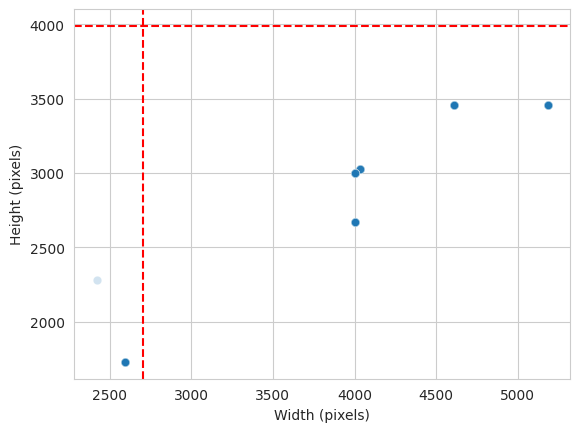

Width average: 3989 
Height average: 2706


In [12]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


Images size for training the model is the average from all images in the train set.

In [13]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(2706, 3989, 3)

* The image resolution is rather high, therefore we need to reduce the images size. However, the aspect ratio should be kept fixed.

In [14]:
from PIL import Image
import os

def resize_images(input_path, new_width=128):
    """
    Resize images in the input_path directory, maintaining aspect ratio, and save them in the same directory with "_reduce" appended to their names.

    Parameters:
    - input_path: The path to the directory containing input images.
    - new_width: The new width of the images.

    Returns:
    None
    """
    # Traverse through the input directory
    for root, dirs, files in os.walk(input_path):
        for file in files:
            # Check if the file is an image (you may need to modify this check based on your file types)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Construct the input file path
                input_file_path = os.path.join(root, file)

                # Open the image using Pillow
                with Image.open(input_file_path) as img:
                    # Calculate the new height to maintain the aspect ratio
                    aspect_ratio = img.width / img.height
                    new_height = int(new_width / aspect_ratio)

                    # Resize the image
                    resized_img = img.resize((new_width, new_height), Image.LANCZOS)

                    # Construct the output file path with "_reduce" appended to the name
                    output_file_path = os.path.join(root, f"{os.path.splitext(file)[0]}_reduce{os.path.splitext(file)[1]}")

                    # Save the resized image in the same directory with "_reduce" appended to the name
                    resized_img.save(output_file_path)



Changing the resolution of all images by defining a parent path

In [15]:
from PIL import Image
import os

def resize_images_in_subfolders(parent_folder, new_width=128):
    """
    Resize images in subfolders of the parent_folder, maintaining aspect ratio, and save them in the same directory with "_reduce" appended to their names.

    Parameters:
    - parent_folder: The path to the parent directory containing subfolders.
    - new_width: The new width of the images.

    Returns:
    None
    """
    # Iterate through subfolders in the parent folder
    for root, dirs, files in os.walk(parent_folder):
        for subfolder in dirs:
            subfolder_path = os.path.join(root, subfolder)
            
            # Check if the subfolder contains "Healthy," "Powdery," and "Rust"
            if all(condition in dirs for condition in ["Healthy", "Powdery", "Rust"]):
                # Apply the resizing function to images in the subfolder
                resize_images(subfolder_path, new_width=new_width)



In [16]:
parent_folder = '../inputs/plants_dataset/'
resize_images_in_subfolders(parent_folder, new_width=256)

Remove all the original images (High-Resolution)

In [18]:
from PIL import Image
import os

def remove_high_resolution_images(parent_folder, max_resolution=(1024, 1024)):
    """
    Remove images with resolution exceeding the specified max_resolution in subfolders of the parent_folder.

    Parameters:
    - parent_folder: The path to the parent directory containing subfolders.
    - max_resolution: A tuple representing the maximum allowed resolution (width, height).

    Returns:
    None
    """
    # Iterate through subfolders in the parent folder
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Check if the file is an image (you may need to modify this check based on your file types)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Open the image using Pillow to get its dimensions
                with Image.open(file_path) as img:
                    # Check if the image resolution exceeds the specified max_resolution
                    if img.width > max_resolution[0] or img.height > max_resolution[1]:
                        # Remove the high-resolution image
                        os.remove(file_path)


* Since the resolution of images was set at 256, in the below we set the minimum Resolution to 260 to avoid removing images

In [19]:
parent_folder = '../inputs/plants_dataset/'
remove_high_resolution_images(parent_folder, max_resolution=(260, 260))

Re-compute average images size on train set.

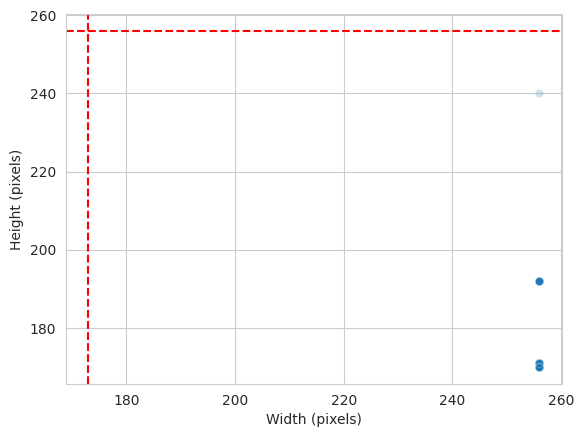

Width average: 256 
Height average: 173


In [20]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


Save the image shape embeddings

In [21]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(173, 256, 3)

In [22]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and variability of images  per label

### Function to load images in an array (tensor)

In [23]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


### Load image shapes and labels in an array

In [24]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)


(90, 173, 256, 3) (90,)


### Plot and save mean and variability of images per label

In [25]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")


==== Label Healthy ====
Image Shape: (173, 256, 3)
==== Label Powdery ====
Image Shape: (173, 256, 3)
==== Label Rust ====
Image Shape: (173, 256, 3)


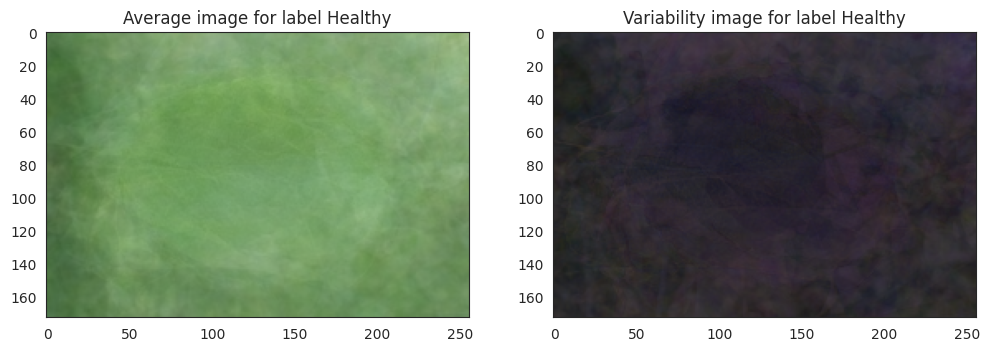

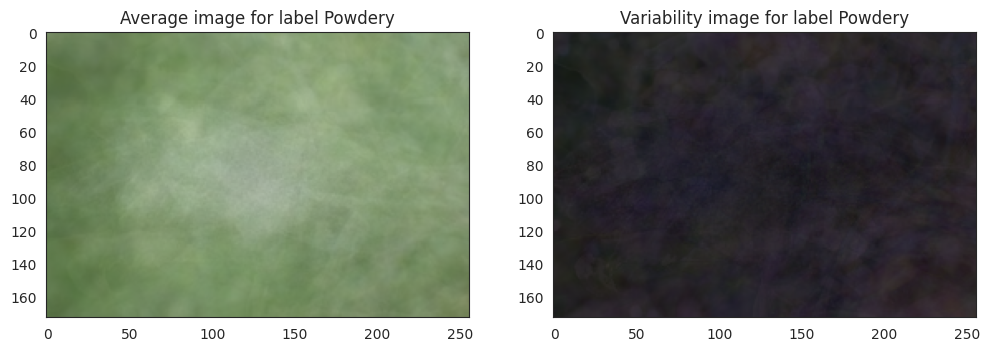

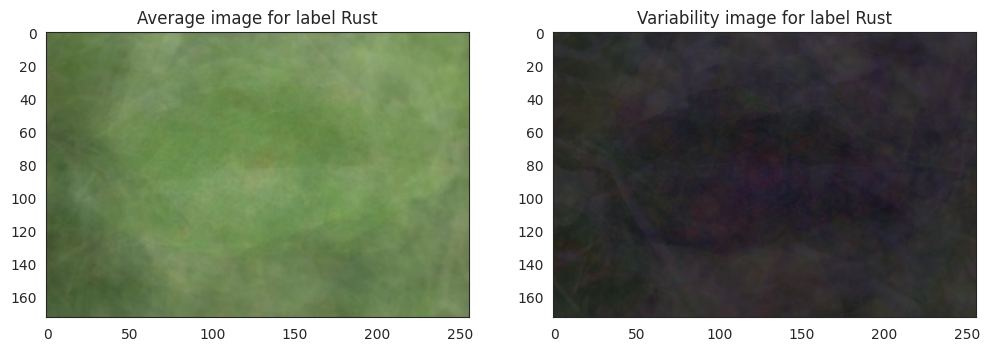

In [26]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)


---

## Difference between average Healthy, average Powdery and average Rust images

---

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, label_3=None, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1, label2, and label3 (if provided)
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    unique_labels = np.unique(y)

    if (label_1 not in unique_labels) or (label_2 not in unique_labels) or (label_3 and label_3 not in unique_labels):
        print("One or more labels are not in the set of unique labels.")
        return

    # calculate mean from label_1
    images_label_1 = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label_1, axis=0)

    # calculate mean from label_2
    images_label_2 = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label_2, axis=0)

    # calculate differences and plot images for label_1 and label_2
    num_subplots = 3
    fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=figsize)

    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')

    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')

    difference_mean_1_2 = label1_avg - label2_avg
    axes[2].imshow(difference_mean_1_2, cmap='gray')
    axes[2].set_title(f'Difference: Avg {label_1} & {label_2}')

    if save_image:
        plt.savefig("avg_diff_label1_label2.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

    # calculate mean from label_3 (if provided)
    if label_3:
        images_label_3 = subset_image_label(X, y, label_3)
        label3_avg = np.mean(images_label_3, axis=0)

        # calculate differences and plot images for label_1 and label_3
        fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=figsize)

        axes[0].imshow(label1_avg, cmap='gray')
        axes[0].set_title(f'Average {label_1}')

        axes[1].imshow(label3_avg, cmap='gray')
        axes[1].set_title(f'Average {label_3}')

        difference_mean_1_3 = label1_avg - label3_avg
        axes[2].imshow(difference_mean_1_3, cmap='gray')
        axes[2].set_title(f'Difference: Avg {label_1} & {label_3}')

        if save_image:
            plt.savefig("avg_diff_label1_label3.png", bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


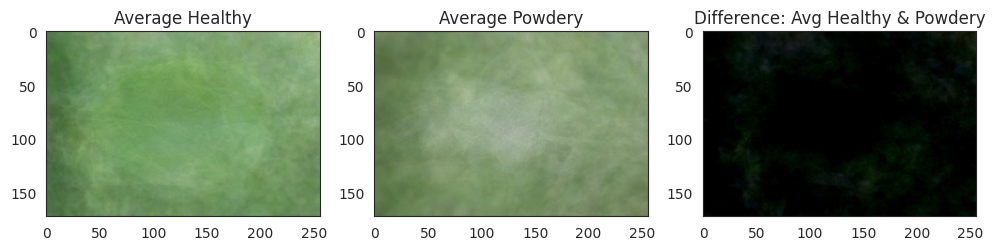

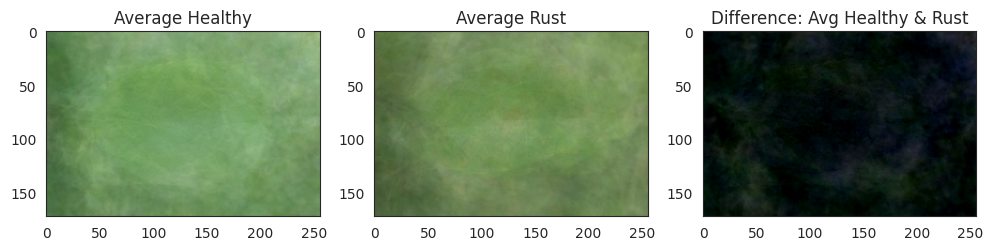

In [28]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='Healthy', label_2='Powdery', label_3='Rust' ,
                                        figsize=(12, 10),
                                        save_image=True
                                        )


---

## Image Montage

In [29]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")


Run Montage in all labels

Healthy


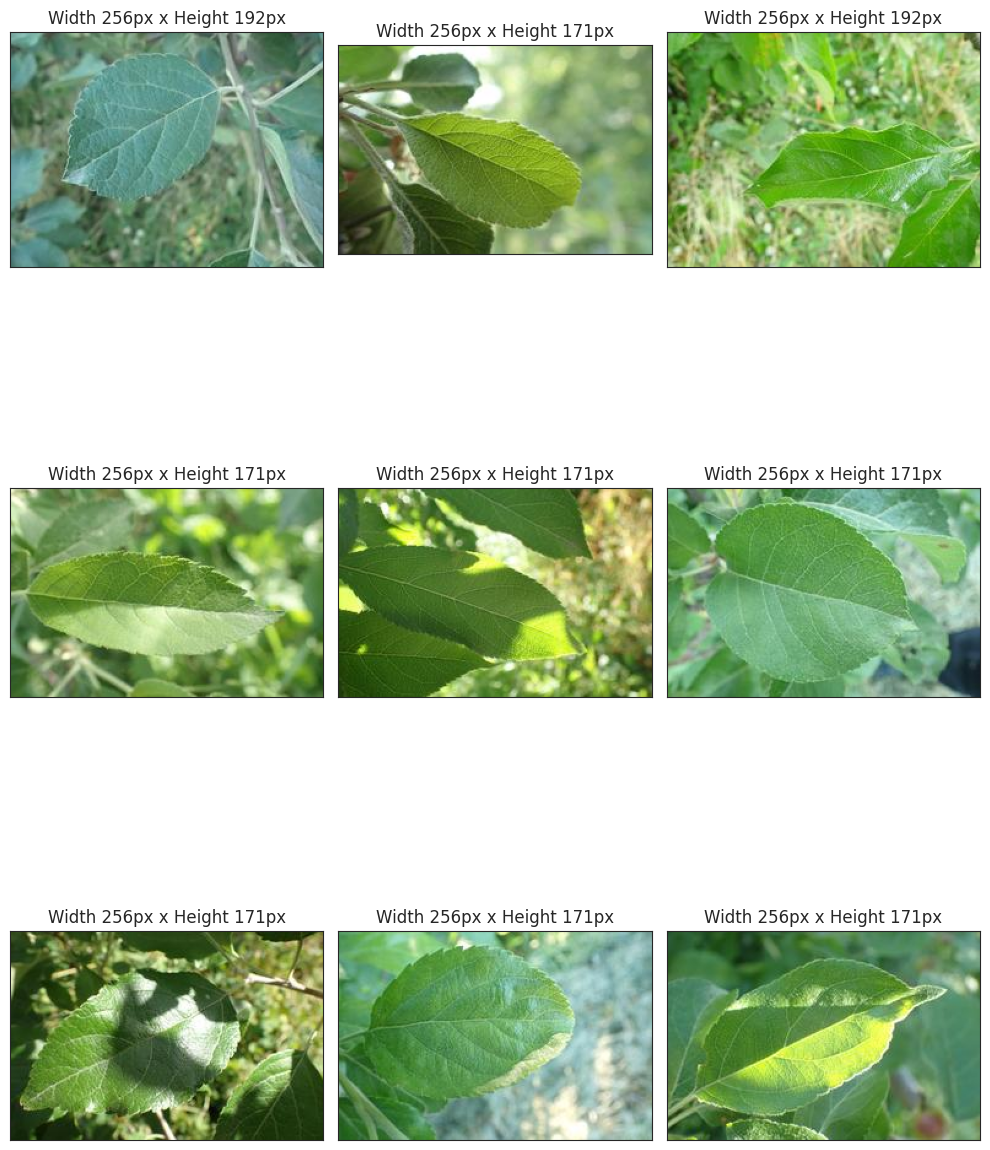



Powdery


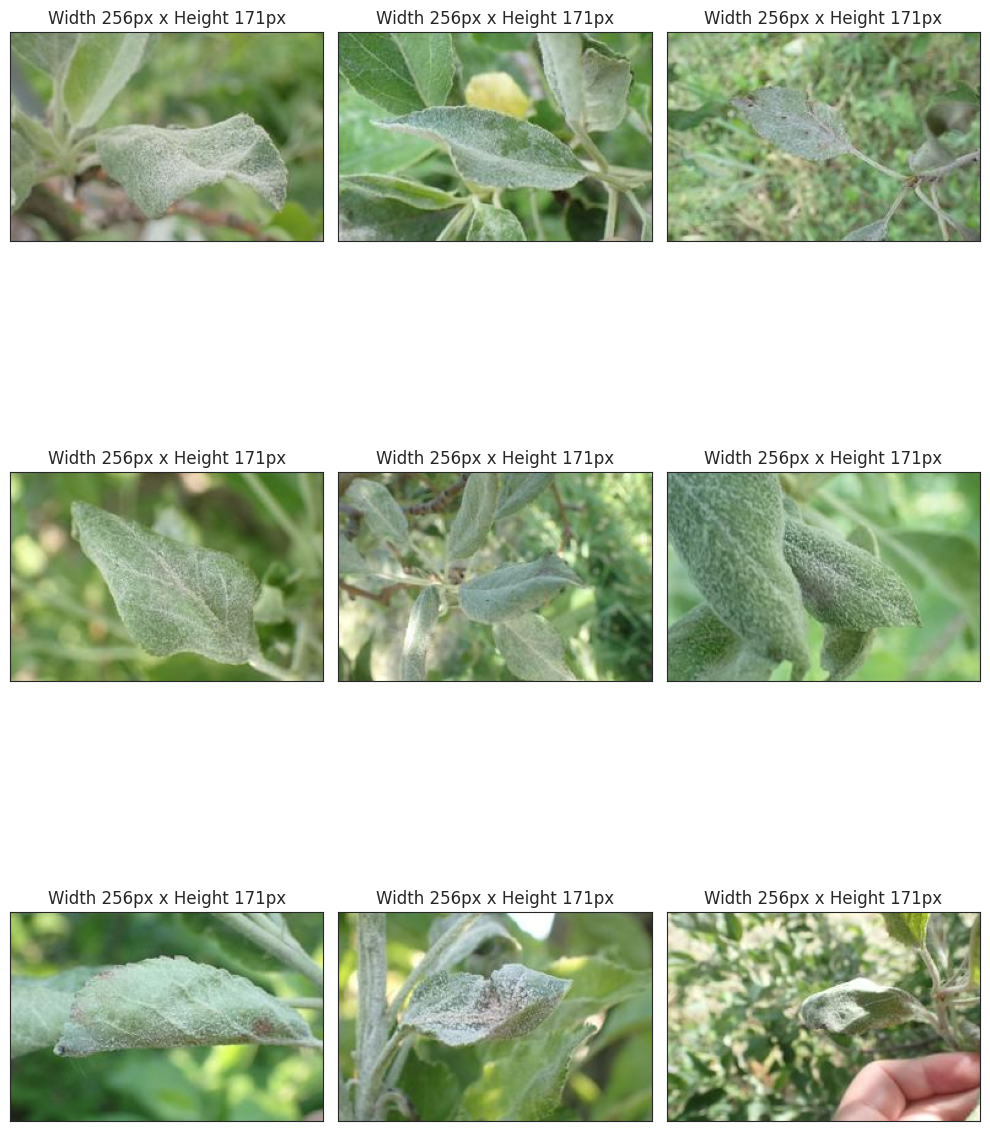



Rust


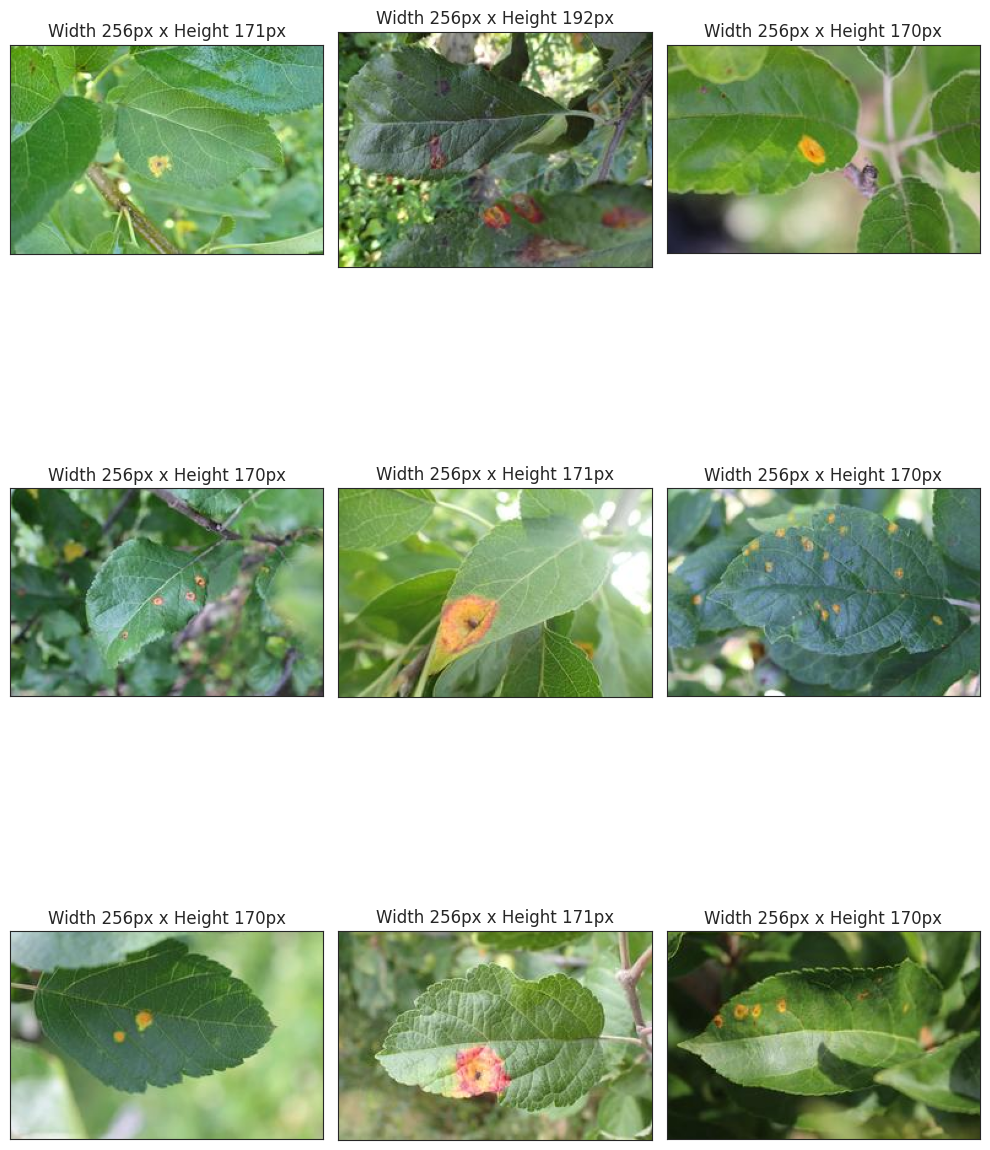

In [30]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")


---

# Congratulations

---